# BASICS 03 - HOTS with online classification (Grimaldi et al. 2022)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset)
num_sample_train = len(loader)
num_sample_test = len(testset)
print(f'number of samples in the training set: {len(loader)}')

number of samples in the training set: 48


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-04-27'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e3, 4e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

device -> cuda


## Unsupervised clustering

In [5]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold, record = True)

## Training of the classification layer

In [6]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 2e4

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
trainloader = get_loader(trainset_output)
classif_layer, losses = fit_mlr(trainloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

In [9]:
import numpy as np
from tqdm import tqdm

nb_trials = 10
n_classes = len(testset.classes)

std_jit_s = np.logspace(0,2,20)
var_jit_s = std_jit_s**2
scores_jit_s = np.zeros([nb_trials, len(var_jit_s)])
scores_jit_s_histo = np.zeros([nb_trials, len(var_jit_s)])

torch.set_default_tensor_type("torch.DoubleTensor")

for trial in tqdm(range(nb_trials)):
    for ind_jit, spatial_jitter in enumerate(var_jit_s):
        if spatial_jitter==0:
            jitter = (None,None)
        else:
            jitter = (spatial_jitter,None)
        test_path = f'../Records/output/test/{initial_name}_{trial}_{num_sample_test}_{jitter}/'
        results_path = f'../Records/LR_results/{initial_name}_{trial}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
        hots.name = initial_name+f'_{trial}'
        
        spatial_jitter_transform = tonic.transforms.SpatialJitter(sensor_size = trainset.sensor_size, variance_x = spatial_jitter, variance_y = spatial_jitter, clip_outliers = True)
        spatial_jitter_transform_full = tonic.transforms.Compose([spatial_jitter_transform, type_transform])
        testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=spatial_jitter_transform_full)
        loader = get_loader(testset)
        hots.coding(loader, testset.ordering, testset.classes, filtering_threshold, training=False, jitter = jitter, verbose=False)
        
        testset_output = HOTS_Dataset(test_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
        testloader = get_loader(testset_output)
        
        likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testloader,results_path,ts_size,testset_output.ordering)
        meanac, onlinac, lastac, _, _ = score_classif_events(likelihood, true_target, n_classes, verbose=False)
        
        scores_jit_s_histo[trial,ind_jit] = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
        scores_jit_s[trial,ind_jit] = lastac
        
        #print(f'For jitter variance {spatial_jitter} pixels, accuracy is {lastac*100}%')

  0%|                                                                                                                                                                                                                                                  | 0/10 [00:00<?, ?it/s]/home/antoine/homhots/hotsline/hots/utils.py:375: RuntimeWarning: Mean of empty slice
  meanac = np.nanmean(matscor)
/home/antoine/homhots/hotsline/hots/utils.py:375: RuntimeWarning: Mean of empty slice
  meanac = np.nanmean(matscor)
/home/antoine/homhots/hotsline/hots/utils.py:375: RuntimeWarning: Mean of empty slice
  meanac = np.nanmean(matscor)
 10%|███████████████████████▍                                                                                                                                                                                                                  | 1/10 [00:04<00:43,  4.89s/it]/home/antoine/homhots/hotsline/hots/utils.py:375: RuntimeWarning: Mean of empty slice
  meanac = np.nanmean(m

In [ ]:
std_jit_t = np.logspace(2.5,5.5,20)
scores_jit_t = np.zeros([nb_trials, len(std_jit_t)])

torch.set_default_tensor_type("torch.DoubleTensor")

for trial in range(nb_trials):
    for ind_jit, temporal_jitter in enumerate(std_jit_t):
        if temporal_jitter==0:
            jitter = (None,None)
        else:
            jitter = (None,temporal_jitter)
        test_path = f'../Records/output/test/{initial_name}_{trial}_{num_sample_test}_{jitter}/'
        results_path = f'../Records/LR_results/{initial_name}_{trial}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
        hots.name = initial_name+f'_{trial}'
        
        tonic.transforms.TimeJitter(std = temporal_jitter, clip_negative = True, sort_timestamps = True)
        temporal_jitter_transform = tonic.transforms.TimeJitter(std = temporal_jitter, clip_negative = True, sort_timestamps = True)
        temporal_jitter_transform_full = tonic.transforms.Compose([temporal_jitter_transform, type_transform])
        testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=temporal_jitter_transform_full)
        loader = get_loader(testset)
        hots.coding(loader, testset.ordering, testset.classes, filtering_threshold, training=False, jitter = jitter, verbose=False)
        
        testset_output = HOTS_Dataset(test_path, trainset.sensor_size, dtype=trainset.dtype, transform=type_transform)
        testloader = get_loader(testset_output)
        
        likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testloader,results_path,ts_size,testset_output.ordering)
        meanac, onlinac, lastac, _, _ = score_classif_events(likelihood, true_target, verbose=False)
        
        scores_jit_t[trial,ind_jit] = lastac
        print(f'For jitter standard deviation {temporal_jitter} microsec, accuracy is {lastac*100}%')

In [11]:
import matplotlib.pyplot as plt
plt.semilogx(np.hstack([np.array([0]),std_jit_t]), np.hstack([np.array([1]),scores_jit_t.mean(axis=0)]), 'o')

NameError: name 'std_jit_t' is not defined

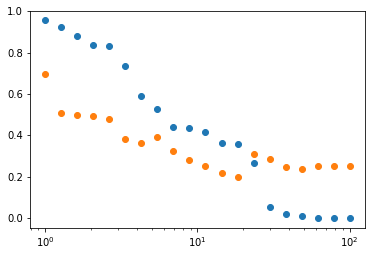

In [12]:
plt.semilogx(std_jit_s, scores_jit_s.mean(axis=0), 'o')
plt.semilogx(std_jit_s, scores_jit_s_histo.mean(axis=0), 'o')